In [1]:
%cd ../..

/app


In [2]:
from tensorairspace.optimization import HyperParamOptimizationOptuna
from tensorairspace.agent.ihdp.model import IHDPAgent
from tensorairspace.utils import generate_time_period
from tensorairspace.signals import unit_step

In [3]:
import numpy as np
import gym

In [4]:
opt = HyperParamOptimizationOptuna(direction='minimize')

[I 2022-12-13 00:20:05,752] A new study created in memory with name: no-name-f13563be-c424-42a4-9707-c2f5325195ee


In [5]:
dt = 0.01
tp = generate_time_period(tn=20)

In [6]:
number_time_steps = len(tp)

In [7]:
reference_signals = np.reshape(unit_step(degree=5, tp=tp, time_step=10, output_rad=True), [1, -1])

In [8]:
def objective(trial):

    env = gym.make('LinearLongitudinalF16-v0',
               number_time_steps=number_time_steps,
               initial_state=[[0], [0], [0], [0]],
               reference_signal=reference_signals,
               tracking_states=["alpha"])
    env.reset()

    actor_settings = {
        "start_training": trial.suggest_int("start_training", 5, 7, log=True),
        "layers": (trial.suggest_int("actor_layers", 20, 25, log=True), 1),
        "activations": ('tanh', 'tanh'),
        "learning_rate": trial.suggest_int("learning_rate", 2, 5, log=True),
        "learning_rate_exponent_limit": 10,
        "type_PE": "combined",
        "amplitude_3211": 15,
        "pulse_length_3211": 5 / dt,
        "maximum_input": 25,
        "maximum_q_rate": 20,
        "WB_limits": 30,
        "NN_initial": 120,
        "cascade_actor": False,
        "learning_rate_cascaded": 1.2
    }
    incremental_settings = {
        "number_time_steps": number_time_steps,
        "dt": dt,
        "input_magnitude_limits":25,
        "input_rate_limits":60,
    }
    critic_settings = {
        "Q_weights": [trial.suggest_int('Q_weights', 7, 9)], 
        "start_training": -1, 
        "gamma": 0.99, 
        "learning_rate": 15, 
        "learning_rate_exponent_limit": 10,
        "layers": (trial.suggest_int("critic_layers", 20, 25, log=True),1),
        "activations": ("tanh", "linear"), 
        "WB_limits": 30,
        "NN_initial": 120,
        "indices_tracking_states": env.indices_tracking_states
    }
    


    model = IHDPAgent(actor_settings, critic_settings, incremental_settings,
                      env.tracking_states, env.state_space, env.control_space, 
                      number_time_steps, env.indices_tracking_states)
    xt = np.array([[np.deg2rad(3)], [0]])
    for step in range(number_time_steps-1):
        ut = model.predict(xt, reference_signals, step)
        xt, reward, done, info = env.step(np.array(ut))
    return reward

In [9]:
opt.run_optimization(objective, n_trials=10)

2022-12-13 00:20:06.013454: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-13 00:20:06.013469: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-13 00:20:06.013482: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-12-13 00:20:06.013582: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-12-13 00:20:06.036027: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3600000000 Hz
2022-12-13 00:20:06.036287: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb8f8000b60 initialized for platform Host (this does not gua

In [10]:
opt.get_best_param()

{'start_training': 5,
 'actor_layers': 25,
 'learning_rate': 5,
 'Q_weights': 8,
 'critic_layers': 25}

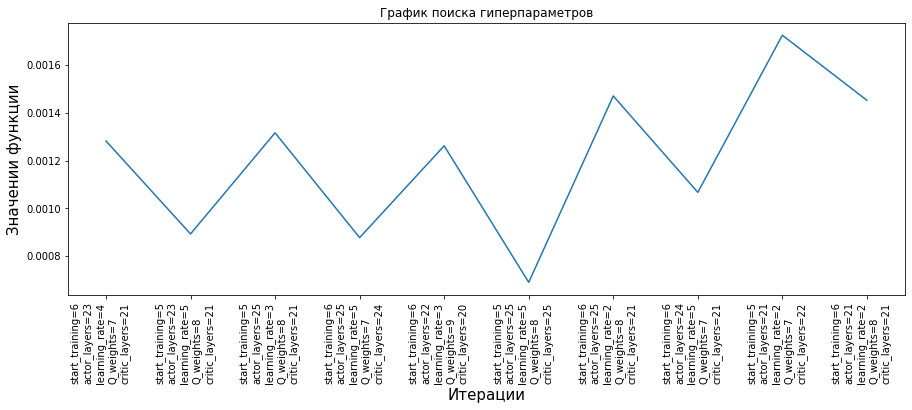

In [11]:
opt.plot_parms()